You are welcome to use the CIFAR-10 data for this exercise. You are welcome to use Python with user-defined functions, Python with TensorFlow, and/or Python with Keras. For example, you can conduct the following experiments on the CIFAR-10 data. The goal is to compare DNN and CNN architectures.

Experiment 1: DNN with 2 layers (no regularization)

Experiment 2: DNN with 3 layers (no regularization)

Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

Experiment 4: CNN with 3 convolution/max pooling layers (no regularization)

Experiment 5+ : You will conduct several more experiments. (a) Redo all the 4 experiments with some regularization technique. (b) Create more experiments on your own by tweaking architectures and/or hyper parameters.

Bottomline: You NEED to do at least 10 experiments or more.

Result1:  Create a table with the accuracy and loss for train/test/validation & process time for ALL the models.

Result2: Take Experiment 3 – Extract the outputs from 2 filters from the 2 max pooling layers and visualize them in a grid as images. See whether the ‘lighted’ up regions correspond to some features in the original images.

In [1]:
import numpy as np
import pandas as pd
from packaging import version

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [3]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)

    x = x[indices]
    y = y[indices]

    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)

    x = x[indices]
    y = y[indices]

    y = tf.keras.utils.to_categorical(y)

    return x, y

In [4]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')


In [5]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


In [7]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


In [8]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


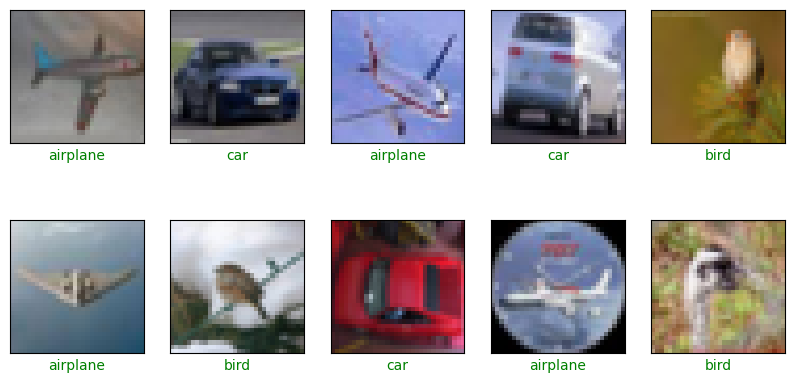

In [9]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)
class_names_preview = ['airplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

In [10]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

In [11]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [12]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255
y_train_norm = y_test/255

Experiment 1

In [13]:
k.clear_session()
model_1 = Sequential([
        Flatten(input_shape=(32, 32, 3)),   # Input layer (flattening the 32x32x3 images)
        Dense(128, activation='relu'),      # First hidden layer with 128 neurons and ReLU activation
        Dense(10, activation='softmax')
])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394634 (1.51 MB)
Trainable params: 394634 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [15]:
history = model_1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

Epoch 1/200
704/704 [==============================] - 7s 9ms/step - loss: 1.9330 - accuracy: 0.3066 - val_loss: 1.8252 - val_accuracy: 0.3504
Epoch 2/200
 11/704 [..............................] - ETA: 7s - loss: 1.8284 - accuracy: 0.3381

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 6s 9ms/step - loss: 1.7700 - accuracy: 0.3727 - val_loss: 1.7698 - val_accuracy: 0.3694
Epoch 3/200
704/704 [==============================] - 5s 7ms/step - loss: 1.7097 - accuracy: 0.3944 - val_loss: 1.7723 - val_accuracy: 0.3724
Epoch 4/200
704/704 [==============================] - 6s 9ms/step - loss: 1.6682 - accuracy: 0.4074 - val_loss: 1.6832 - val_accuracy: 0.4036
Epoch 5/200
704/704 [==============================] - 5s 8ms/step - loss: 1.6399 - accuracy: 0.4189 - val_loss: 1.6815 - val_accuracy: 0.4042
Epoch 6/200
704/704 [==============================] - 6s 9ms/step - loss: 1.6199 - accuracy: 0.4243 - val_loss: 1.6517 - val_accuracy: 0.4124
Epoch 7/200
704/704 [==============================] - 5s 8ms/step - loss: 1.6040 - accuracy: 0.4281 - val_loss: 1.6712 - val_accuracy: 0.4012
Epoch 8/200
704/704 [==============================] - 6s 8ms/step - loss: 1.5924 - accuracy: 0.4350 - val_loss: 1.7035 - val_accuracy: 0.3904
Epoch 9/200

In [16]:
pred1= model_1.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 2ms/step


In [17]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      1000
           1       0.48      0.62      0.54      1000
           2       0.39      0.17      0.24      1000
           3       0.31      0.20      0.24      1000
           4       0.39      0.37      0.38      1000
           5       0.34      0.37      0.36      1000
           6       0.50      0.42      0.45      1000
           7       0.46      0.54      0.50      1000
           8       0.53      0.60      0.57      1000
           9       0.40      0.59      0.47      1000

    accuracy                           0.44     10000
   macro avg       0.43      0.44      0.42     10000
weighted avg       0.43      0.44      0.42     10000

Accuracy Score: 0.4363
Root Mean Square Error: 3.393611645430278


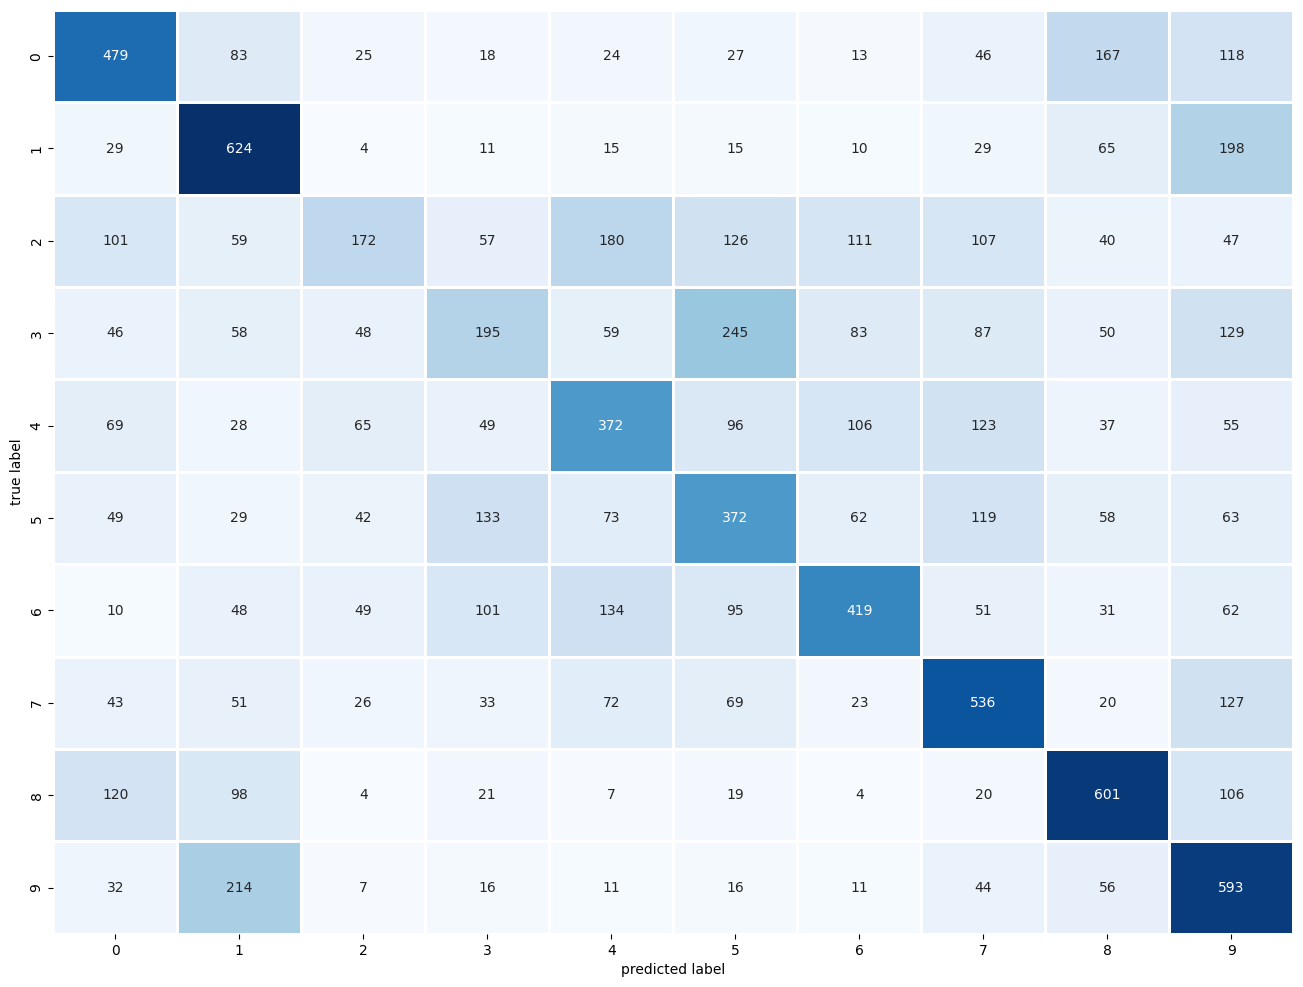

In [18]:
plot_confusion_matrix(y_test,pred1)

Experiment 2

In [19]:
k.clear_session()
model_2 = Sequential([
        Flatten(input_shape=(32, 32, 3)),   # Input layer (flattening the 32x32x3 images)
        Dense(128, activation='relu'),
        Dense (64, activation = 'relu'), # First hidden layer with 128 neurons and ReLU activation
        Dense(10, activation='softmax')
])
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 402250 (1.53 MB)
Trainable params: 402250 (1.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [21]:
history2 = model_2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

Epoch 1/200
704/704 [==============================] - 7s 9ms/step - loss: 1.8911 - accuracy: 0.3135 - val_loss: 1.7956 - val_accuracy: 0.3580
Epoch 2/200
 11/704 [..............................] - ETA: 7s - loss: 1.7603 - accuracy: 0.3778

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 6s 8ms/step - loss: 1.7273 - accuracy: 0.3834 - val_loss: 1.7156 - val_accuracy: 0.3774
Epoch 3/200
704/704 [==============================] - 5s 8ms/step - loss: 1.6518 - accuracy: 0.4104 - val_loss: 1.6631 - val_accuracy: 0.4100
Epoch 4/200
704/704 [==============================] - 6s 9ms/step - loss: 1.6037 - accuracy: 0.4275 - val_loss: 1.6142 - val_accuracy: 0.4178
Epoch 5/200
704/704 [==============================] - 5s 7ms/step - loss: 1.5643 - accuracy: 0.4393 - val_loss: 1.6014 - val_accuracy: 0.4216
Epoch 6/200
704/704 [==============================] - 6s 9ms/step - loss: 1.5331 - accuracy: 0.4541 - val_loss: 1.5993 - val_accuracy: 0.4304
Epoch 7/200
704/704 [==============================] - 5s 7ms/step - loss: 1.5102 - accuracy: 0.4634 - val_loss: 1.5793 - val_accuracy: 0.4290
Epoch 8/200
704/704 [==============================] - 6s 9ms/step - loss: 1.4939 - accuracy: 0.4674 - val_loss: 1.5546 - val_accuracy: 0.4374
Epoch 9/200

In [22]:
pred2 = model_2.predict(x_test_norm)
pred2 = np.argmax(pred2, axis=1)

313/313 [==============================] - 1s 2ms/step


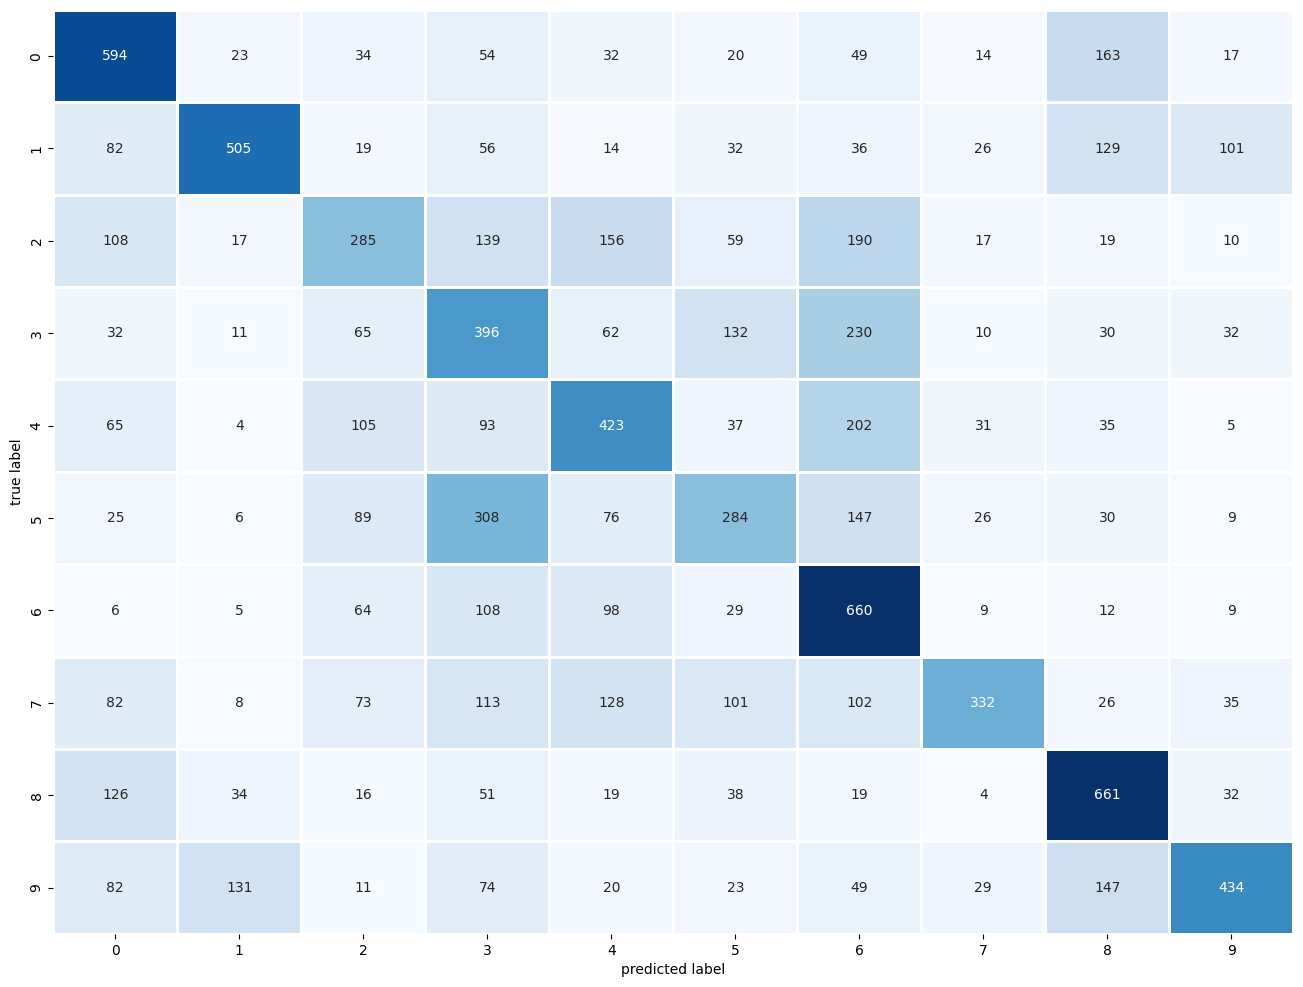

In [23]:
plot_confusion_matrix(y_test,pred2)

Experiment 3

In [24]:
# For TensorFlow
k.clear_session()

k.clear_session()
model_3 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)
])
model_3.summary()
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

In [25]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

In [26]:
history3 = model_3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=3
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

Epoch 1/3
704/704 [==============================] - 541s 767ms/step - loss: 1.6878 - accuracy: 0.4143 - val_loss: 1.4369 - val_accuracy: 0.5088
Epoch 2/3


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 536s 761ms/step - loss: 1.3357 - accuracy: 0.5569 - val_loss: 1.2155 - val_accuracy: 0.5988
Epoch 3/3
704/704 [==============================] - 529s 751ms/step - loss: 1.1930 - accuracy: 0.6156 - val_loss: 1.1333 - val_accuracy: 0.6290


313/313 [==============================] - 31s 98ms/step


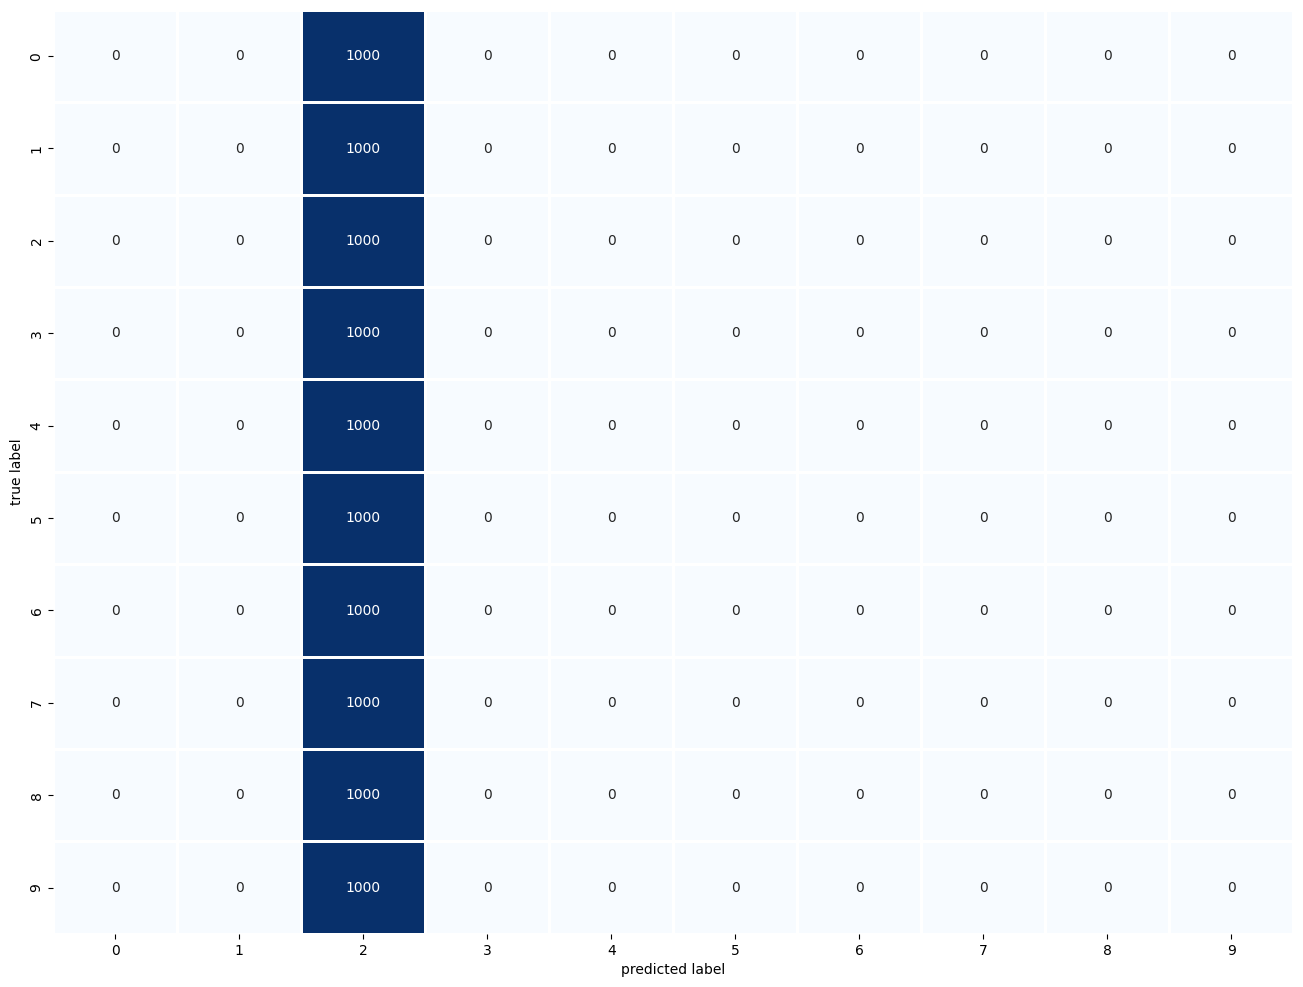

In [78]:
pred3= model_3.predict(x_test_norm)
pred3=np.argmax(pred3, axis=1)

plot_confusion_matrix(y_test, pred3)

Experiment 4

In [27]:
k.clear_session()

# Define common parameters
kernel_size = (3, 3)
pool_size = (2, 2)
dropout_rate = 0.3

# Define model layers
model_layers = [
    Conv2D(filters=128, kernel_size=kernel_size, strides=(1, 1), activation='relu', input_shape=x_train_norm.shape[1:]),
    MaxPool2D(pool_size=pool_size, strides=2),
    Dropout(dropout_rate),

    Conv2D(filters=256, kernel_size=kernel_size, strides=(1, 1), activation='relu'),
    MaxPool2D(pool_size=pool_size, strides=2),
    Dropout(dropout_rate),

    Conv2D(filters=512, kernel_size=kernel_size, strides=(1, 1), activation='relu'),
    MaxPool2D(pool_size=pool_size, strides=2),
    Dropout(dropout_rate),

    Flatten(),
    Dense(units=384, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    BatchNormalization(),
    Dropout(dropout_rate),

    Dense(units=10, activation='softmax')
]

# Create Sequential model
model_4 = Sequential(model_layers)

# Display model summary
model_4.summary()

# Compile the model
model_4.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

In [28]:
history4 = model_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=3
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

Epoch 1/3
704/704 [==============================] - 540s 765ms/step - loss: 1.9565 - accuracy: 0.4180 - val_loss: 1.5601 - val_accuracy: 0.4998
Epoch 2/3
704/704 [==============================] - 525s 745ms/step - loss: 1.3743 - accuracy: 0.5744 - val_loss: 1.2367 - val_accuracy: 0.6124
Epoch 3/3
704/704 [==============================] - 533s 757ms/step - loss: 1.1889 - accuracy: 0.6306 - val_loss: 1.1806 - val_accuracy: 0.6320


313/313 [==============================] - 32s 101ms/step


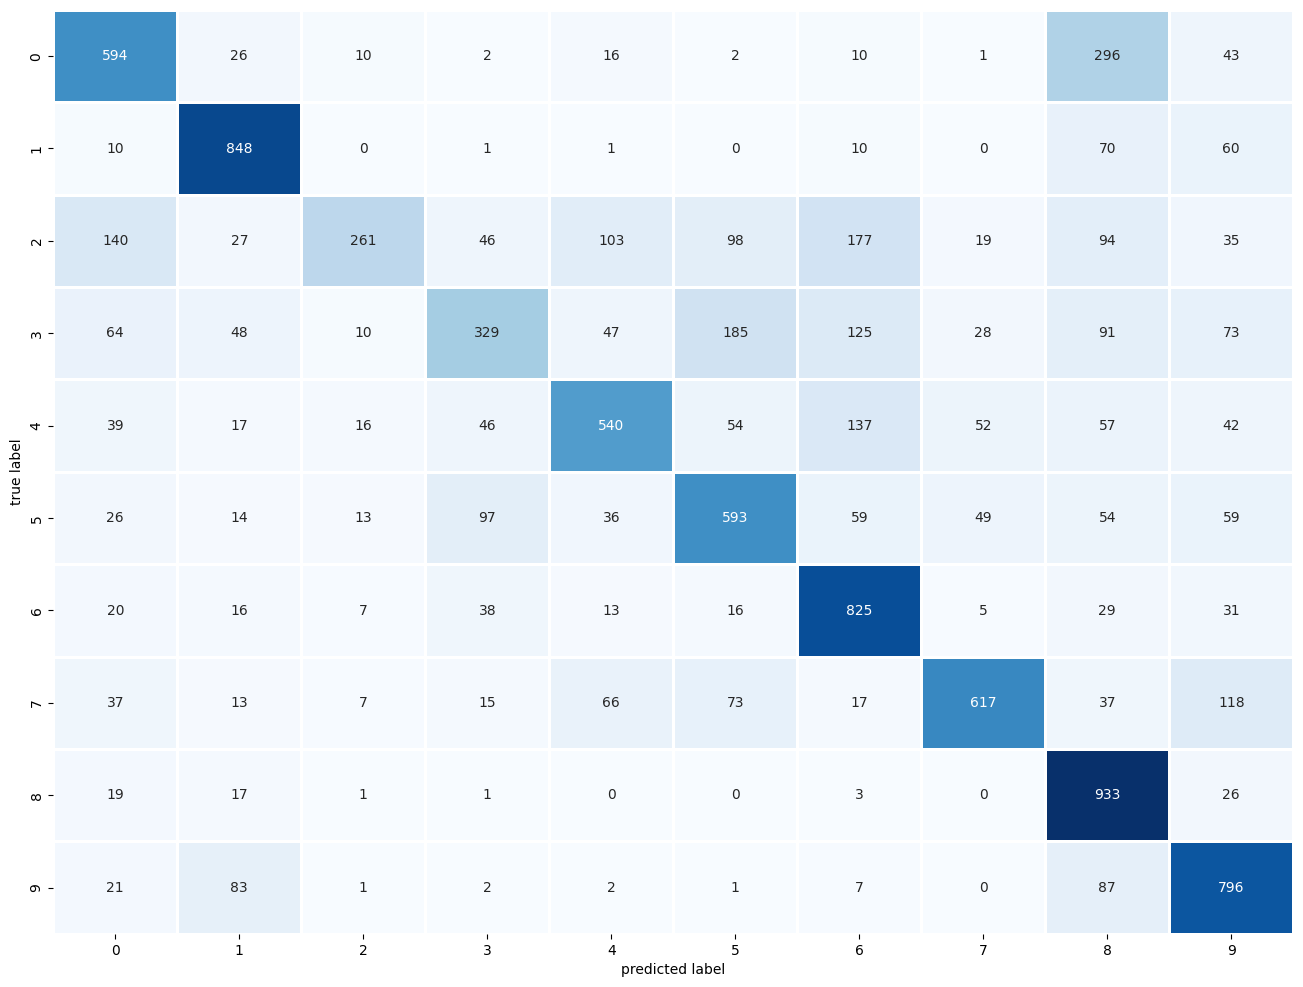

In [79]:
pred4= model_4.predict(x_test_norm)
pred4=np.argmax(pred4, axis=1)

plot_confusion_matrix(y_test, pred4)

Experiment 5

In [31]:
model_5 = Sequential([
    Flatten(input_shape=(32, 32, 3)),          # Input layer (flattening the 32x32x3 images)
    Dense(128, activation='relu'),             # First hidden layer with 128 neurons and ReLU activation
    Dropout(0.5),                              # Dropout layer for regularization
    Dense(10, activation='softmax')
])

# Display model summary
model_5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               393344    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394634 (1.51 MB)
Trainable params: 394634 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
model_5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history5 = model_5.fit(x_train_norm
                    ,y_train_split
                    ,epochs=3
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


704/704 [==============================] - 7s 9ms/step - loss: 2.2352 - accuracy: 0.1390 - val_loss: 2.0963 - val_accuracy: 0.2040
Epoch 2/3
 17/704 [..............................] - ETA: 4s - loss: 2.1952 - accuracy: 0.1664

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 5s 7ms/step - loss: 2.1907 - accuracy: 0.1439 - val_loss: 2.1125 - val_accuracy: 0.1834
Epoch 3/3
704/704 [==============================] - 6s 8ms/step - loss: 2.1797 - accuracy: 0.1458 - val_loss: 2.1167 - val_accuracy: 0.1812


In [33]:
pred5= model_5.predict(x_test_norm)
pred5=np.argmax(pred5, axis=1)

313/313 [==============================] - 1s 2ms/step


In [34]:
print_validation_report(y_test, pred5)

Classification Report
              precision    recall  f1-score   support

           0       0.15      0.32      0.21      1000
           1       1.00      0.00      0.00      1000
           2       0.11      0.03      0.05      1000
           3       0.00      0.00      0.00      1000
           4       0.06      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.22      0.56      0.32      1000
           7       0.17      0.53      0.26      1000
           8       0.00      0.00      0.00      1000
           9       0.25      0.50      0.33      1000

    accuracy                           0.19     10000
   macro avg       0.20      0.19      0.12     10000
weighted avg       0.20      0.19      0.12     10000

Accuracy Score: 0.1936
Root Mean Square Error: 4.350206891631707


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


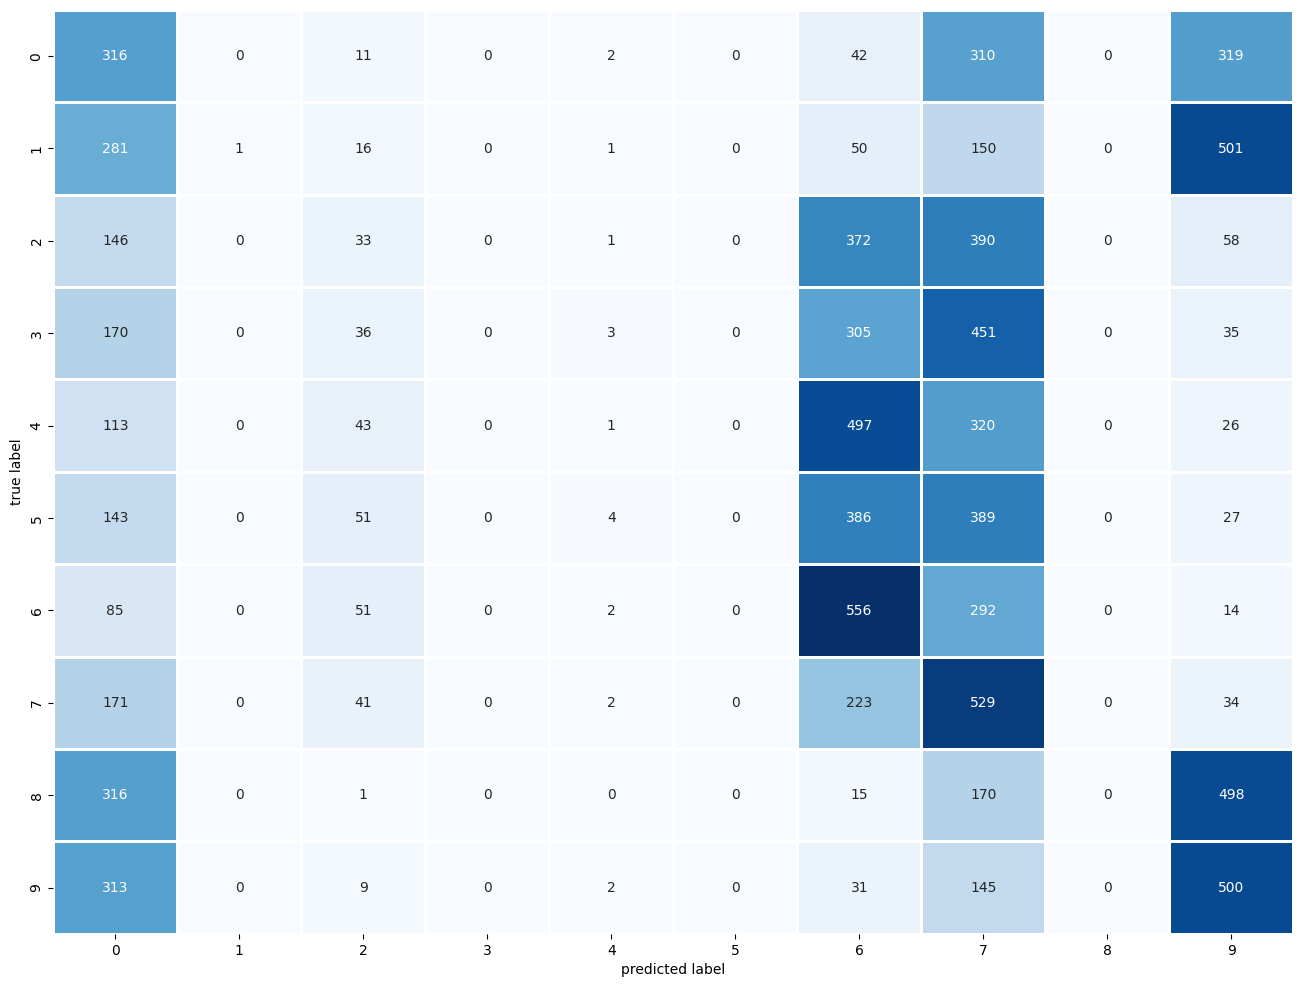

In [36]:
plot_confusion_matrix(y_test,pred5)

Experiment 6

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf

# Clear the session
tf.keras.backend.clear_session()

# Create Sequential model with L2 regularization
model_6 = Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,
           input_shape=x_train_norm.shape[1:], kernel_regularizer=regularizers.L2(0.001)),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.3),

    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,
           kernel_regularizer=regularizers.L2(0.001)),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.3),

    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,
           kernel_regularizer=regularizers.L2(0.001)),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.3),

    Flatten(),

    Dense(units=384, activation=tf.nn.softmax, kernel_regularizer=regularizers.L2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(units=10, activation=tf.nn.softmax)
])

# Display model summary
model_6.summary()

# Compile the model
model_6.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

In [39]:
history6 = model_6.fit(x_train_norm
                    ,y_train_split
                    ,epochs=3
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

Epoch 1/3
704/704 [==============================] - 555s 786ms/step - loss: 1.8644 - accuracy: 0.3814 - val_loss: 1.6564 - val_accuracy: 0.4716
Epoch 2/3


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 597s 848ms/step - loss: 1.5808 - accuracy: 0.5071 - val_loss: 1.4737 - val_accuracy: 0.5462
Epoch 3/3
704/704 [==============================] - 534s 758ms/step - loss: 1.5010 - accuracy: 0.5529 - val_loss: 1.4230 - val_accuracy: 0.5648


In [40]:
pred6 = model_6.predict(x_test_norm)
pred6 = np.argmax(pred6, axis=1)

313/313 [==============================] - 43s 137ms/step


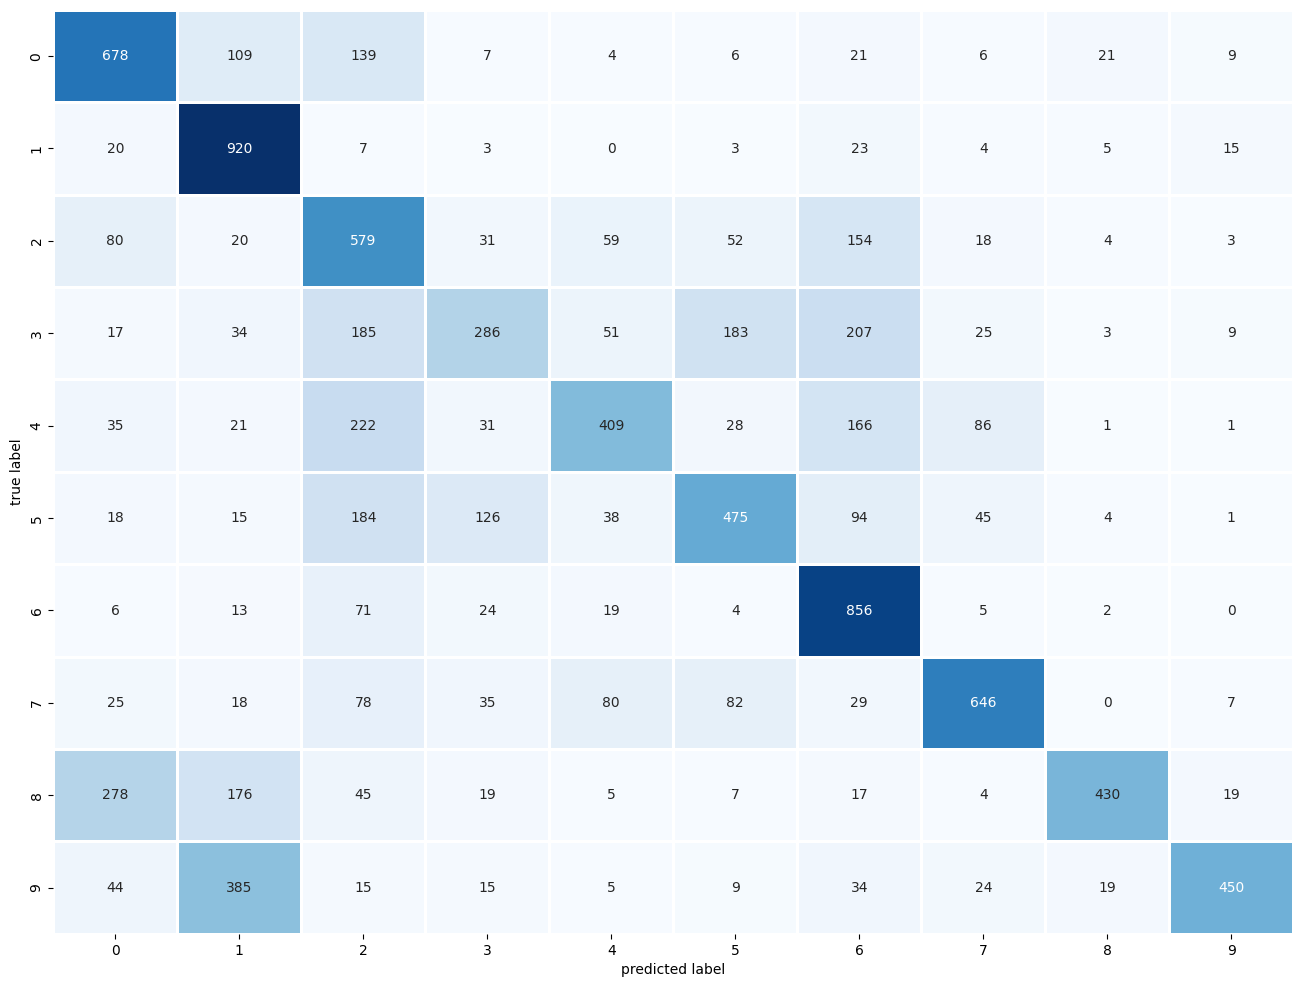

In [48]:
plot_confusion_matrix(y_test, pred6)

Experiment 7

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf

# Clear the session
tf.keras.backend.clear_session()

# Create Sequential model with L2 regularization
model_7 = Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,
           input_shape=x_train_norm.shape[1:], kernel_regularizer=regularizers.L2(0.001)),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.3),

    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,
           kernel_regularizer=regularizers.L2(0.001)),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.3),

    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,
           kernel_regularizer=regularizers.L2(0.001)),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.3),

    Flatten(),

    Dense(units=384, activation=tf.nn.softmax, kernel_regularizer=regularizers.L2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(units=10, activation=tf.nn.softmax)
])

# Display model summary
model_7.summary()

# Compile the model
model_7.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

In [45]:
history7 = model_7.fit(x_train_norm
                    ,y_train_split
                    ,epochs=3
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

Epoch 1/3
704/704 [==============================] - 564s 802ms/step - loss: 1.8817 - accuracy: 0.3686 - val_loss: 1.6637 - val_accuracy: 0.4630
Epoch 2/3


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 546s 776ms/step - loss: 1.5945 - accuracy: 0.4999 - val_loss: 1.6264 - val_accuracy: 0.5038
Epoch 3/3
704/704 [==============================] - 549s 780ms/step - loss: 1.5170 - accuracy: 0.5437 - val_loss: 1.4102 - val_accuracy: 0.5738


In [49]:
pred7 = model_7.predict(x_test_norm)
pred7 = np.argmax(pred7, axis=1)

313/313 [==============================] - 48s 152ms/step


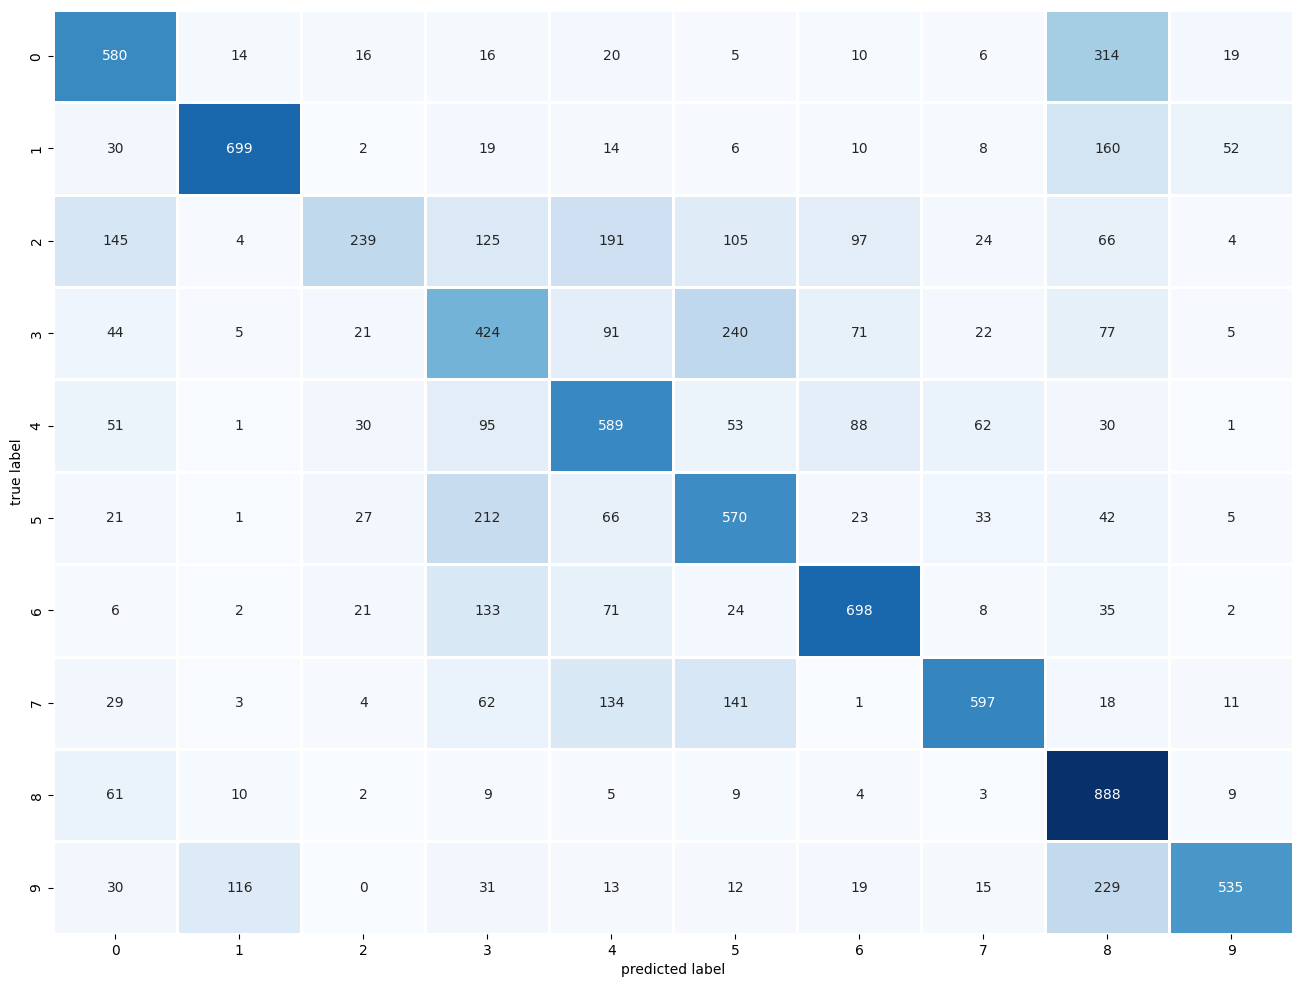

In [50]:
plot_confusion_matrix(y_test, pred7)

Experiment 8

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf

# Clear the session
tf.keras.backend.clear_session()

# Define common parameters
kernel_size = (3, 3)
pool_size = (2, 2)
dropout_rate = 0.3

# Define model layers with L2 regularization
model_layers = [
    Conv2D(filters=128, kernel_size=kernel_size, strides=(1, 1), activation='relu',
           input_shape=x_train_norm.shape[1:], kernel_regularizer=regularizers.L2(0.001)),
    MaxPool2D(pool_size=pool_size, strides=2),
    Dropout(dropout_rate),

    Conv2D(filters=256, kernel_size=kernel_size, strides=(1, 1), activation='relu',
           kernel_regularizer=regularizers.L2(0.001)),
    MaxPool2D(pool_size=pool_size, strides=2),
    Dropout(dropout_rate),

    Conv2D(filters=512, kernel_size=kernel_size, strides=(1, 1), activation='relu',
           kernel_regularizer=regularizers.L2(0.001)),
    MaxPool2D(pool_size=pool_size, strides=2),
    Dropout(dropout_rate),

    Flatten(),

    Dense(units=384, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    BatchNormalization(),
    Dropout(dropout_rate),

    Dense(units=10, activation='softmax')
]

# Create Sequential model
model_8 = Sequential(model_layers)

# Display model summary
model_8.summary()

# Compile the model
model_8.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

In [47]:
history = model_8.fit(x_train_norm
                    ,y_train_split
                    ,epochs=3
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

Epoch 1/3
704/704 [==============================] - 559s 792ms/step - loss: 2.2933 - accuracy: 0.4012 - val_loss: 1.7613 - val_accuracy: 0.5004
Epoch 2/3


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 550s 781ms/step - loss: 1.5931 - accuracy: 0.5616 - val_loss: 1.6192 - val_accuracy: 0.5286
Epoch 3/3
704/704 [==============================] - 543s 771ms/step - loss: 1.4359 - accuracy: 0.6093 - val_loss: 1.4034 - val_accuracy: 0.6122


In [51]:
pred8 = model_8.predict(x_test_norm)
pred8 = np.argmax(pred8, axis=1)

313/313 [==============================] - 29s 93ms/step


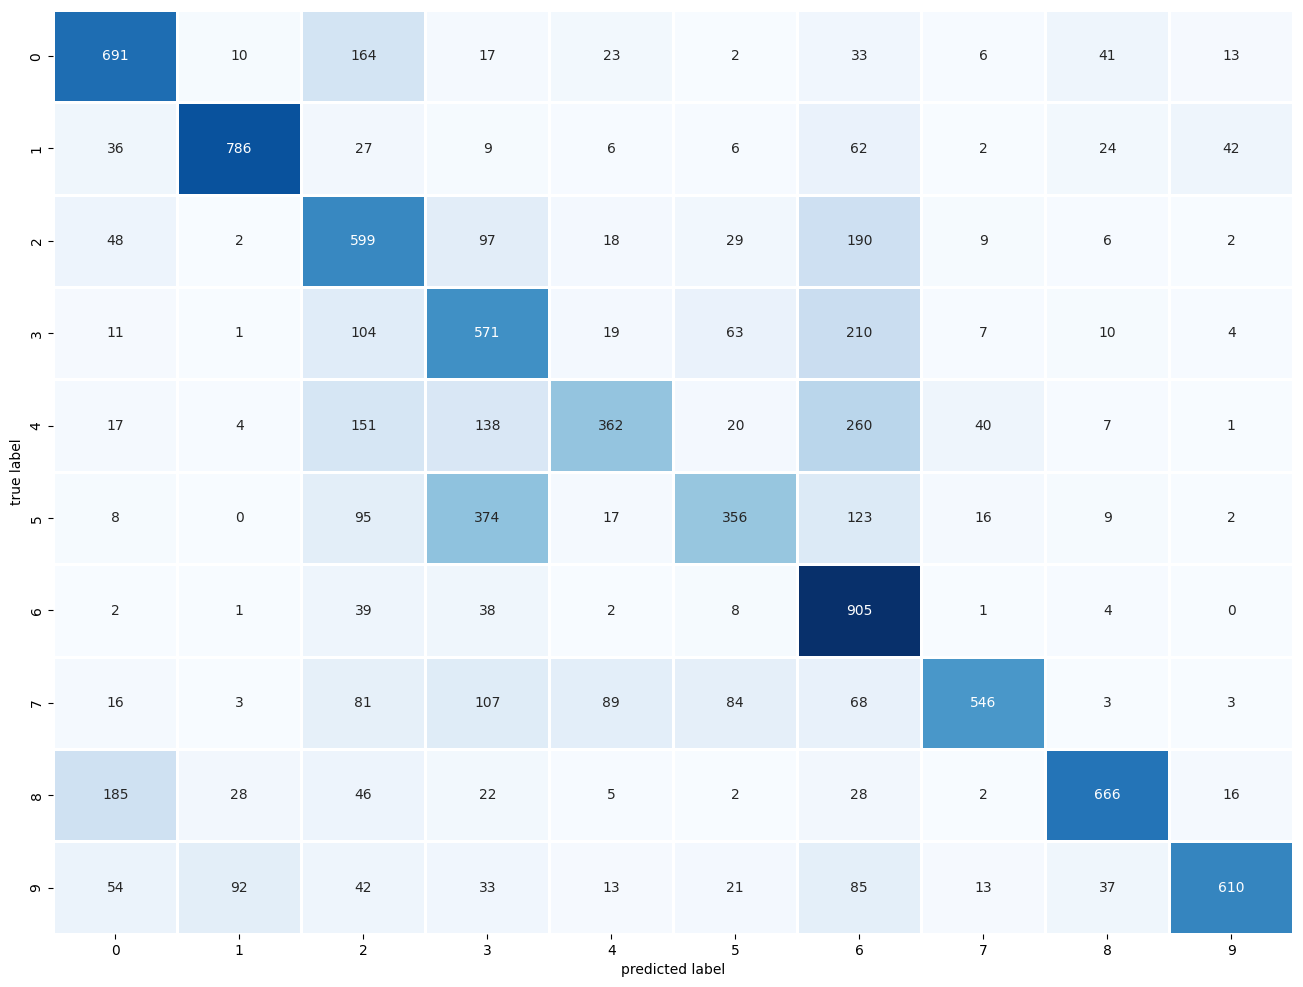

In [52]:
plot_confusion_matrix(y_test, pred8)

Experiment 9

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf

# Clear the session
tf.keras.backend.clear_session()

# Define common parameters
kernel_size = (3, 3)
pool_size = (2, 2)
dropout_rate = 0.3

# Define model layers with L2 regularization
model_layers = [
    Conv2D(filters=128, kernel_size=kernel_size, strides=(1, 1), activation='relu',
           input_shape=x_train_norm.shape[1:], kernel_regularizer=regularizers.L2(0.001)),
    MaxPool2D(pool_size=pool_size, strides=2),
    Dropout(dropout_rate),

    Conv2D(filters=128, kernel_size=kernel_size, strides=(1, 1), activation='relu',
           kernel_regularizer=regularizers.L2(0.001)),
    MaxPool2D(pool_size=pool_size, strides=2),
    Dropout(dropout_rate),

    Conv2D(filters=256, kernel_size=kernel_size, strides=(1, 1), activation='relu',
           kernel_regularizer=regularizers.L2(0.001)),
    Dropout(dropout_rate),

    Flatten(),

    Dense(units=10, activation='softmax')
]

# Create Sequential model
model_9 = Sequential(model_layers)

# Display model summary
model_9.summary()

# Compile the model
model_9.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

In [61]:

history = model_9.fit(x_train_norm
                    ,y_train_split
                    ,epochs=3
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

Epoch 1/3
704/704 [==============================] - 333s 472ms/step - loss: 1.7194 - accuracy: 0.4056 - val_loss: 1.5050 - val_accuracy: 0.4852
Epoch 2/3


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 290s 413ms/step - loss: 1.4040 - accuracy: 0.5347 - val_loss: 1.3347 - val_accuracy: 0.5614
Epoch 3/3
704/704 [==============================] - 282s 401ms/step - loss: 1.2975 - accuracy: 0.5828 - val_loss: 1.1882 - val_accuracy: 0.6238


313/313 [==============================] - 15s 47ms/step


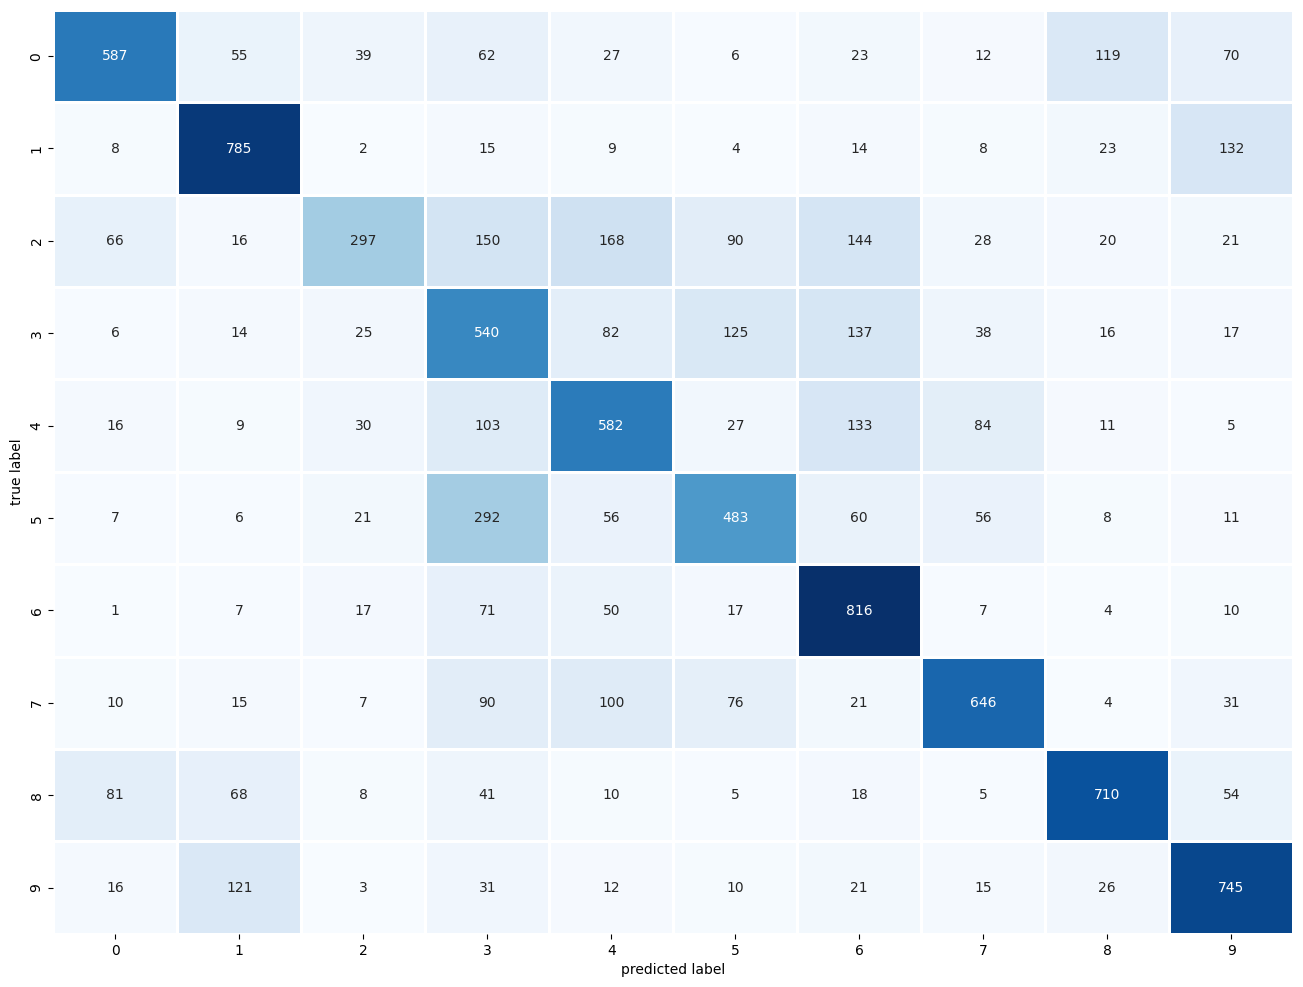

In [62]:
pred9 = model_9.predict(x_test_norm)
pred9 = np.argmax(pred9, axis=1)

plot_confusion_matrix(y_test, pred9)

Experiment 10

In [65]:
k.clear_session()
model_10 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)
])
model_10.summary()
model_10.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

In [66]:
history = model_10.fit(x_train_norm
                    ,y_train_split
                    ,epochs=3
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

Epoch 1/3
704/704 [==============================] - 578s 819ms/step - loss: 1.6669 - accuracy: 0.4228 - val_loss: 1.3958 - val_accuracy: 0.5326
Epoch 2/3


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 557s 791ms/step - loss: 1.3057 - accuracy: 0.5660 - val_loss: 1.1718 - val_accuracy: 0.6066
Epoch 3/3
704/704 [==============================] - 557s 791ms/step - loss: 1.1658 - accuracy: 0.6227 - val_loss: 1.0321 - val_accuracy: 0.6692


313/313 [==============================] - 29s 94ms/step


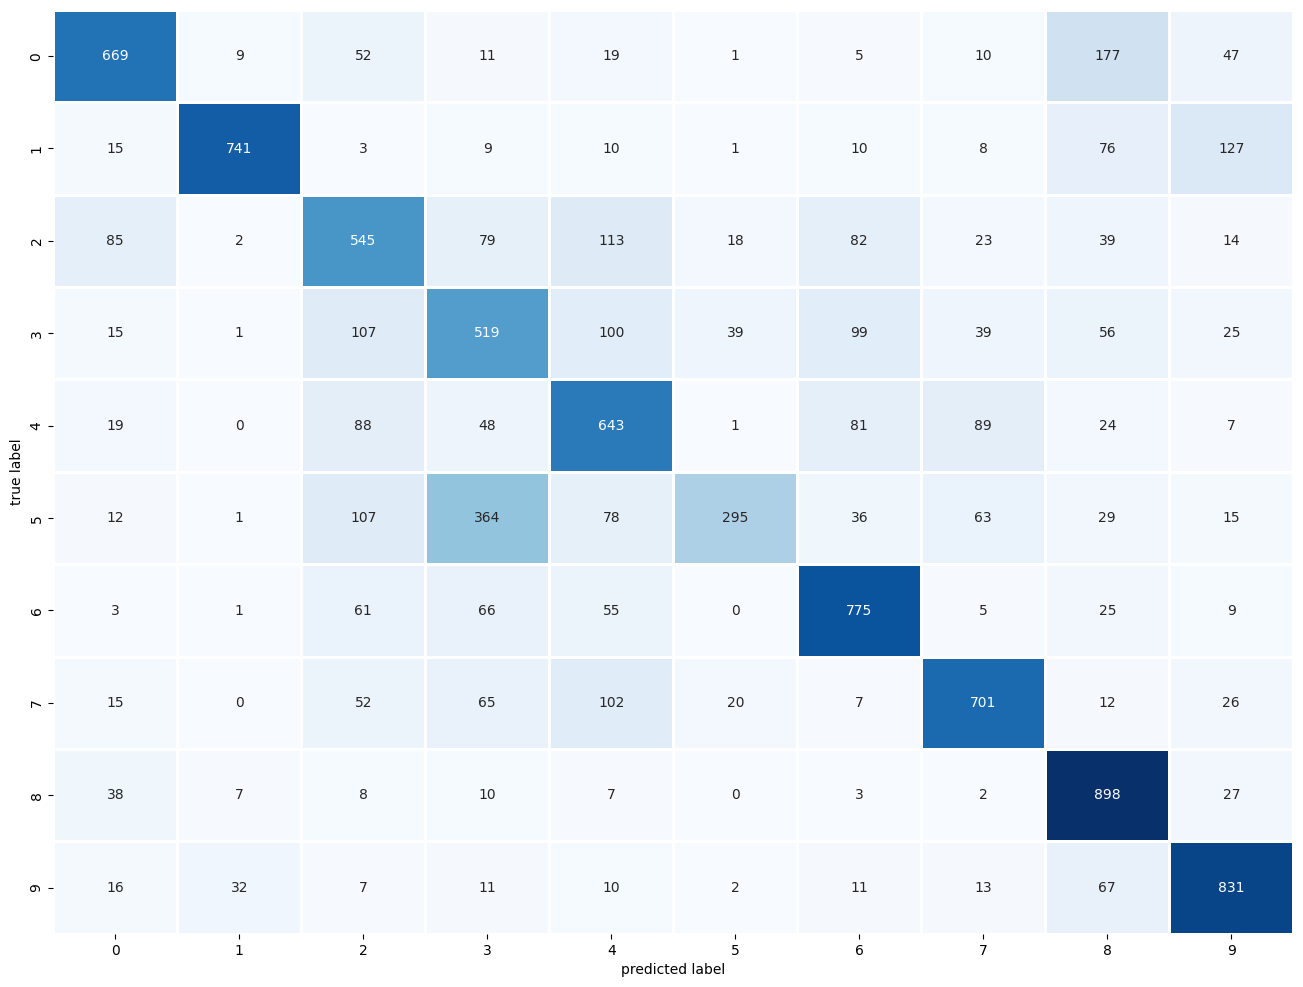

In [67]:
pred10 = model_10.predict(x_test_norm)
pred10 = np.argmax(pred10, axis=1)

plot_confusion_matrix(y_test, pred10)

Result1: Create a table with the accuracy and loss for train/test/validation & process time for ALL the models.

Result2: Take Experiment 3 – Extract the outputs from 2 filters from the 2 max pooling layers and visualize them in a grid as images. See whether the ‘lighted’ up regions correspond to some features in the original images.

Result 1:

In [116]:
val1 = print_validation_report(y_test, pred1)
val1 = pd.DataFrame(val1)

Classification Report
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      1000
           1       0.48      0.62      0.54      1000
           2       0.39      0.17      0.24      1000
           3       0.31      0.20      0.24      1000
           4       0.39      0.37      0.38      1000
           5       0.34      0.37      0.36      1000
           6       0.50      0.42      0.45      1000
           7       0.46      0.54      0.50      1000
           8       0.53      0.60      0.57      1000
           9       0.40      0.59      0.47      1000

    accuracy                           0.44     10000
   macro avg       0.43      0.44      0.42     10000
weighted avg       0.43      0.44      0.42     10000

Accuracy Score: 0.4363
Root Mean Square Error: 3.393611645430278


In [115]:
val2 = print_validation_report(y_test, pred2)
val2 = pd.DataFrame(val2)

Classification Report
              precision    recall  f1-score   support

           0       0.49      0.59      0.54      1000
           1       0.68      0.51      0.58      1000
           2       0.37      0.28      0.32      1000
           3       0.28      0.40      0.33      1000
           4       0.41      0.42      0.42      1000
           5       0.38      0.28      0.32      1000
           6       0.39      0.66      0.49      1000
           7       0.67      0.33      0.44      1000
           8       0.53      0.66      0.59      1000
           9       0.63      0.43      0.52      1000

    accuracy                           0.46     10000
   macro avg       0.48      0.46      0.46     10000
weighted avg       0.48      0.46      0.46     10000

Accuracy Score: 0.4574
Root Mean Square Error: 3.0772227738660716


In [90]:
val3 = print_validation_report(y_test, pred3)

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.10      1.00      0.18      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

Accuracy Score: 0.1
Root Mean Square Error: 3.8078865529319543


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
val4 = print_validation_report(y_test, pred4)

Classification Report
              precision    recall  f1-score   support

           0       0.61      0.59      0.60      1000
           1       0.76      0.85      0.80      1000
           2       0.80      0.26      0.39      1000
           3       0.57      0.33      0.42      1000
           4       0.66      0.54      0.59      1000
           5       0.58      0.59      0.59      1000
           6       0.60      0.82      0.70      1000
           7       0.80      0.62      0.70      1000
           8       0.53      0.93      0.68      1000
           9       0.62      0.80      0.70      1000

    accuracy                           0.63     10000
   macro avg       0.65      0.63      0.62     10000
weighted avg       0.65      0.63      0.62     10000

Accuracy Score: 0.6336
Root Mean Square Error: 2.6797387932408636


In [92]:
val5 = print_validation_report(y_test, pred5)

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.10      1.00      0.18      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

Accuracy Score: 0.1
Root Mean Square Error: 3.8078865529319543


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
val6 = print_validation_report(y_test, pred6)

Classification Report
              precision    recall  f1-score   support

           0       0.56      0.68      0.62      1000
           1       0.54      0.92      0.68      1000
           2       0.38      0.58      0.46      1000
           3       0.50      0.29      0.36      1000
           4       0.61      0.41      0.49      1000
           5       0.56      0.47      0.51      1000
           6       0.53      0.86      0.66      1000
           7       0.75      0.65      0.69      1000
           8       0.88      0.43      0.58      1000
           9       0.88      0.45      0.59      1000

    accuracy                           0.57     10000
   macro avg       0.62      0.57      0.56     10000
weighted avg       0.62      0.57      0.56     10000

Accuracy Score: 0.5729
Root Mean Square Error: 2.9504575916287967


In [100]:
val7 = print_validation_report(y_test, pred7)

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.58      0.58      1000
           1       0.82      0.70      0.75      1000
           2       0.66      0.24      0.35      1000
           3       0.38      0.42      0.40      1000
           4       0.49      0.59      0.54      1000
           5       0.49      0.57      0.53      1000
           6       0.68      0.70      0.69      1000
           7       0.77      0.60      0.67      1000
           8       0.48      0.89      0.62      1000
           9       0.83      0.54      0.65      1000

    accuracy                           0.58     10000
   macro avg       0.62      0.58      0.58     10000
weighted avg       0.62      0.58      0.58     10000

Accuracy Score: 0.5819
Root Mean Square Error: 2.7402737089568263


In [94]:
val8 = print_validation_report(y_test, pred8)

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.69      0.67      1000
           1       0.85      0.79      0.82      1000
           2       0.44      0.60      0.51      1000
           3       0.41      0.57      0.47      1000
           4       0.65      0.36      0.47      1000
           5       0.60      0.36      0.45      1000
           6       0.46      0.91      0.61      1000
           7       0.85      0.55      0.67      1000
           8       0.83      0.67      0.74      1000
           9       0.88      0.61      0.72      1000

    accuracy                           0.61     10000
   macro avg       0.66      0.61      0.61     10000
weighted avg       0.66      0.61      0.61     10000

Accuracy Score: 0.6092
Root Mean Square Error: 2.4959366979152335


In [95]:
val9 = print_validation_report(y_test, pred9)

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.59      0.65      1000
           1       0.72      0.79      0.75      1000
           2       0.66      0.30      0.41      1000
           3       0.39      0.54      0.45      1000
           4       0.53      0.58      0.56      1000
           5       0.57      0.48      0.52      1000
           6       0.59      0.82      0.68      1000
           7       0.72      0.65      0.68      1000
           8       0.75      0.71      0.73      1000
           9       0.68      0.74      0.71      1000

    accuracy                           0.62     10000
   macro avg       0.63      0.62      0.61     10000
weighted avg       0.63      0.62      0.61     10000

Accuracy Score: 0.6191
Root Mean Square Error: 2.6030943125442074


In [96]:
val10 = print_validation_report(y_test, pred10)

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.67      0.71      1000
           1       0.93      0.74      0.83      1000
           2       0.53      0.55      0.54      1000
           3       0.44      0.52      0.48      1000
           4       0.57      0.64      0.60      1000
           5       0.78      0.29      0.43      1000
           6       0.70      0.78      0.73      1000
           7       0.74      0.70      0.72      1000
           8       0.64      0.90      0.75      1000
           9       0.74      0.83      0.78      1000

    accuracy                           0.66     10000
   macro avg       0.68      0.66      0.66     10000
weighted avg       0.68      0.66      0.66     10000

Accuracy Score: 0.6617
Root Mean Square Error: 2.4222716610652903


In [118]:
# Concatenate along axis 1
combined_values = np.hstack((val1, val2, val3, val4, val5, val6, val7, val8, val9, val10))

print("Combined Values:")
print(combined_values)

Combined Values:
[]


Result 2:

In [69]:
from sklearn.manifold import TSNE

In [70]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model_3.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model_3.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:2000])
dense_layer_activations = activations[-3]

63/63 [==============================] - 9s 136ms/step


In [71]:
tsne = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.308s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000198
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.990013
[t-SNE] KL divergence after 300 iterations: 2.083458


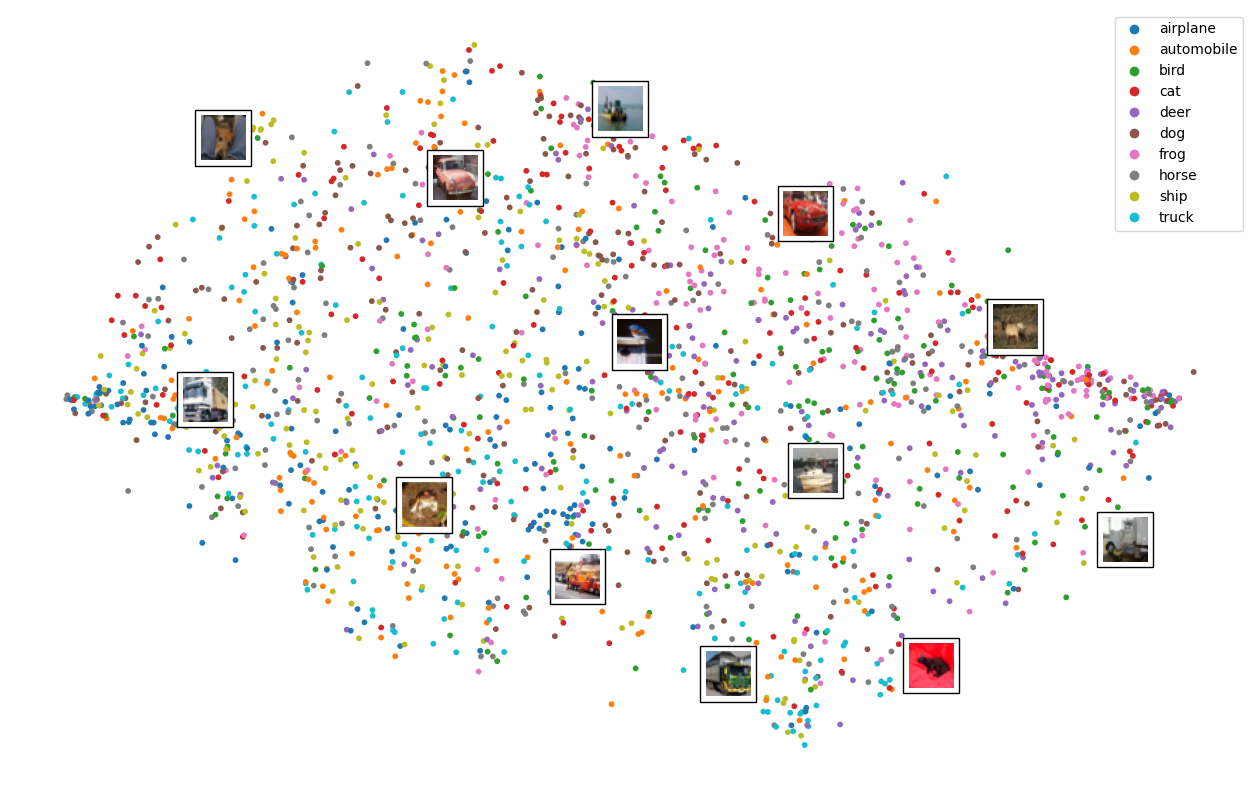

In [73]:
import matplotlib as mpl

cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()